## Spatial autocorrelation

This notebook is the first step. It is meant to look for spatial autocorrelation
within Guadalajara's Properties.

In [1]:
import geopandas as gpd
import pandas as pd
import pysal.explore
import matplotlib.pyplot as plt
import seaborn as sns
import splot.esda
import esda
import libpysal

/home/gus/Documents/github_repos/notes.git/venv/lib/python3.12/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
/home/gus/Documents/github_repos/notes.git/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import properties and venues data
gdf_properties = gpd.read_file('../database/properties.gpkg')
gdf_neighborhoods = gpd.read_file('../database/neighborhoods.gpkg')

# change CRS for meters
gdf_properties = gdf_properties.to_crs(epsg=32614)
gdf_neighborhoods = gdf_neighborhoods.to_crs(epsg=32614)

# numeric cols
numeric_cols = [
    'price_per_m2',
    'bedrooms', 'parking_spaces', 'pool', 'full_bathroom', 'half_bathroom',
    'property_age','gated_community', 'type_Appartment',
    'type_House'
    ]

In [3]:
# create spatial weights with 5 neighbors
w = libpysal.weights.KNN.from_dataframe(gdf_properties[numeric_cols + ['geometry']], k=5)

# Global Moran's I
moran = esda.Moran(gdf_properties['price_per_m2'], w=w)
print(f'Moran\'s I: {moran.I:.4}, p-value: {moran.p_sim}')

# Local Moran's I
lisa = esda.Moran_Local(gdf_properties['price_per_m2'], w=w)
gdf_properties['lisa'] = lisa.q  # 1=HH, 2=LH, 3=LL, 4=HL
gdf_properties['p-value'] = lisa.p_sim  # significance

/home/gus/Documents/github_repos/notes.git/venv/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Moran's I: 0.5625, p-value: 0.001


In [4]:
from scipy.stats import mode

# Spatial join: Map each property to its neighborhood
gdf_joined = gpd.sjoin(gdf_properties, gdf_neighborhoods, how='left',predicate='within')

# Group properties by neighborhood and get mode of lisa.q
gdf_significant = gdf_joined[gdf_joined['p-value'] < 0.05]
neighborhood_lisa = gdf_joined.groupby('index_right')['lisa'].agg(
    lambda x: mode(x, keepdims=False).mode  # Mode of cluster categories
).reset_index()

# Merge back with neighborhood geometries
gdf_neighborhoods_lisa = gdf_neighborhoods.merge(
    neighborhood_lisa,
    left_index=True,
    right_on='index_right', 
    how='left'
)

/tmp/ipykernel_54117/993726500.py:24: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf_neighborhoods_lisa.plot(


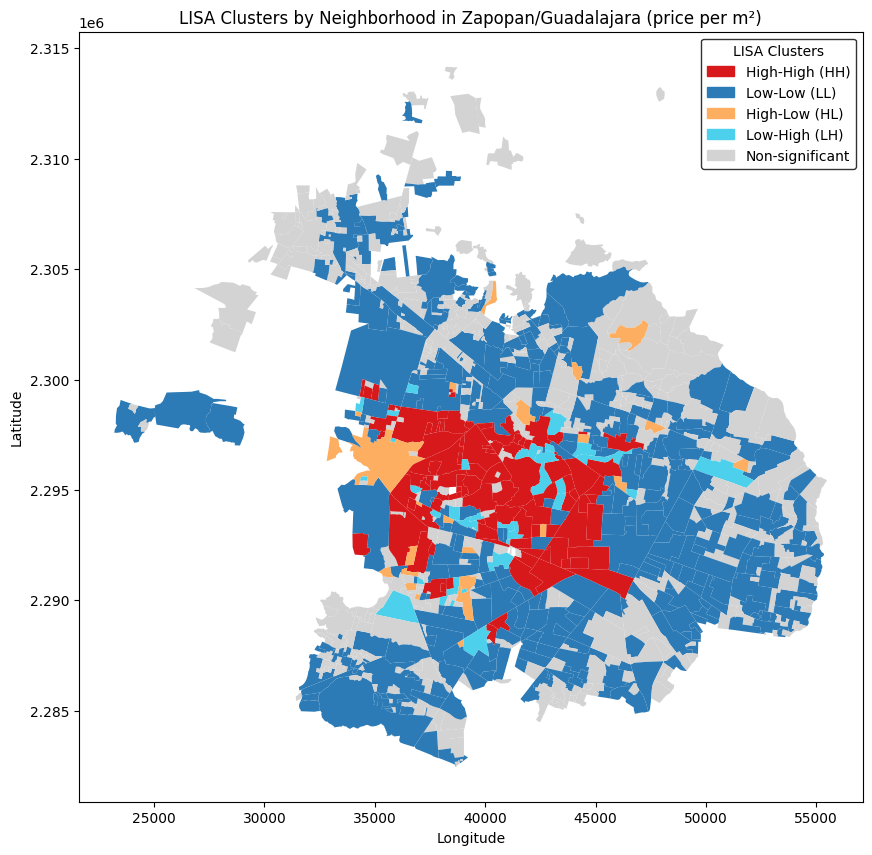

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
gdf_neighborhoods_lisa['lisa'] = gdf_neighborhoods_lisa['lisa'].fillna(0)

# Define colors and labels for LISA categories
lisa_colors = {
    1: '#d7191c',     # HH
    2: '#4DD0EB',    # LH
    3: '#2c7bb6', # LL
    4: '#fdae61',    # HL
    0: '#d3d3d3' # Non-significant
}

lisa_labels = {
    1: 'High-High (HH)',
    2: 'Low-High (LH)',
    3: 'Low-Low (LL)',
    4: 'High-Low (HL)',
    0: 'Non-significant'
}

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
gdf_neighborhoods_lisa.plot(
    column='lisa', 
    color=[lisa_colors[x] for x in gdf_neighborhoods_lisa['lisa']],
    ax=ax,
    legend=True,
    categorical=True,
    legend_kwds={'title': 'LISA Cluster', 'labels': lisa_labels}
)
legend_handles = [
    mpatches.Patch(color=lisa_colors[1], label=lisa_labels[1]),  # HH
    mpatches.Patch(color=lisa_colors[3], label=lisa_labels[3]),  # LL
    mpatches.Patch(color=lisa_colors[4], label=lisa_labels[4]),  # HL
    mpatches.Patch(color=lisa_colors[2], label=lisa_labels[2]),  # LH
    mpatches.Patch(color=lisa_colors[0], label=lisa_labels[0])   # Non-significant
]
# Add legend to the plot
plt.legend(
    handles=legend_handles,
    title='LISA Clusters',
    loc='upper right',
    frameon=True,
    edgecolor='black'
)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('LISA Clusters by Neighborhood in Zapopan/Guadalajara (price per m²)')
plt.show()

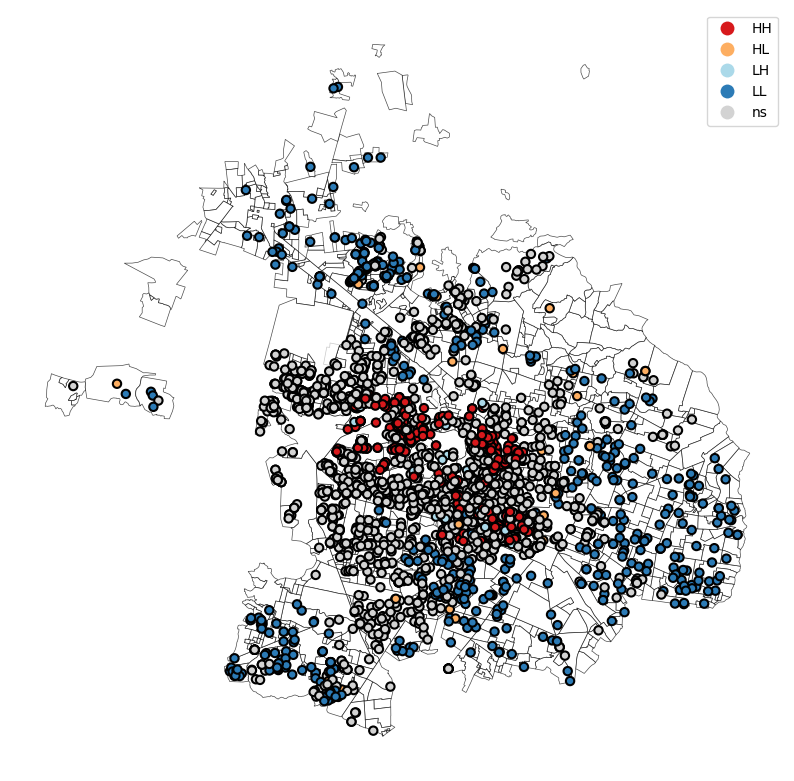

In [6]:
f, ax = plt.subplots(1, figsize=(10, 10))
gdf_neighborhoods.plot(
    ax=ax,
    color='white',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.7
    )
splot.esda.lisa_cluster(lisa, gdf_properties, ax=ax, edgecolor='black')
plt.show()

In [7]:
gdf_properties

,construction,bedrooms,parking_spaces,pool,address,price,link,lat,lon,full_bathroom,...,land,county,neighborhood,price_per_m2,gated_community,type_Appartment,type_House,geometry,lisa,p-value
0,390.0,3,3,1,"Casa en Venta en Bugambilias, Fraccionamient...",11000000.0,https://www.inmuebles24.com/propiedades/clasif...,20.610254,-103.453548,3,...,360.0,Zapopan,Del bosque,28205.128205,1,0,1,POINT (35603.07 2285376.527),3,0.019
1,168.0,3,2,1,"valle real , Valle Real, Zapopan",10900000.0,https://www.inmuebles24.com/propiedades/clasif...,20.724182,-103.446606,2,...,168.0,Zapopan,Valle real,64880.952381,0,1,0,POINT (36674.874 2297993.697),1,0.231
2,165.0,4,2,0,"Parques Vallarta, Acacia, El Bajío, Zapopan",7390000.0,https://www.inmuebles24.com/propiedades/clasif...,20.721817,-103.476100,3,...,218.0,Zapopan,Bosques vallarta,44787.878788,1,0,1,POINT (33589.739 2297816.356),4,0.143
3,306.0,3,2,0,"Paseo San Arturo, Valle Real, Zapopan",14500000.0,https://www.inmuebles24.com/propiedades/clasif...,20.724469,-103.447205,3,...,319.0,Zapopan,Valle real,47385.620915,1,0,1,POINT (36613.225 2298027.176),1,0.343
4,179.0,3,2,1,"Altavista Pte., Altavista Residencial, Zapopan",5700000.0,https://www.inmuebles24.com/propiedades/clasif...,20.767494,-103.406822,2,...,105.0,Zapopan,Coto vitanas,31843.575419,1,0,1,POINT (40957.631 2302683.963),3,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2920,165.0,2,2,0,"circuito del bosque bosques vallarta, Bosque...",4825000.0,https://www.inmuebles24.com/propiedades/clasif...,20.719738,-103.475078,1,...,148.0,Zapopan,Bosques vallarta,29242.424242,1,0,1,POINT (33689.906 2297582.772),3,0.143
2921,110.0,2,2,0,"Calle Otawa , Providencia, Guadalajara",6880000.0,https://www.inmuebles24.com/propiedades/clasif...,20.697823,-103.377228,2,...,110.0,Guadalajara,Circunvalacion americas,62545.454545,0,1,0,POINT (43835.465 2294872.468),1,0.010
2922,136.0,3,2,0,"Grosellos 6, Miravalle, Guadalajara",3050000.0,https://www.inmuebles24.com/propiedades/clasif...,20.609691,-103.341972,2,...,95.0,Guadalajara,Miravalle,22426.470588,0,0,1,POINT (47253.117 2284998.698),3,0.027
2923,121.0,3,2,1,"Av. Servidor Publico, Zona Real, Jardines de...",4990000.0,https://www.inmuebles24.com/propiedades/clasif...,20.741550,-103.430618,2,...,121.0,Zapopan,Jardin real,41239.669421,0,1,0,POINT (38396.125 2299874.27),2,0.266


In [8]:
global_ac = {'Variable':[], 'Morans I':[], 'Morans p-value':[], 'Gearys C':[], 'Gearys p-value':[]}
for var in numeric_cols:
    try:
        morans_stat = esda.moran.Moran(gdf_properties[var], w=w)
        geary_c = esda.geary.Geary(gdf_properties[var], w=w)
        global_ac['Variable'].append(var)
        global_ac['Morans I'].append(morans_stat.I)
        global_ac['Morans p-value'].append(morans_stat.p_sim)
        global_ac['Gearys C'].append(geary_c.C)
        global_ac['Gearys p-value'].append(geary_c.p_sim)
    except:
        print(var)

global_autocor = pd.DataFrame(global_ac)
print(global_autocor.to_markdown(index=False))

| Variable        |   Morans I |   Morans p-value |   Gearys C |   Gearys p-value |
|:----------------|-----------:|-----------------:|-----------:|-----------------:|
| price_per_m2    |   0.562456 |            0.001 |   0.434739 |            0.001 |
| bedrooms        |   0.265306 |            0.001 |   0.729518 |            0.001 |
| parking_spaces  |   0.447566 |            0.001 |   0.548583 |            0.001 |
| pool            |   0.309398 |            0.001 |   0.697403 |            0.001 |
| full_bathroom   |   0.382512 |            0.001 |   0.605439 |            0.001 |
| half_bathroom   |   0.185348 |            0.001 |   0.803326 |            0.001 |
| property_age    |   0.236803 |            0.001 |   0.736967 |            0.001 |
| gated_community |   0.476967 |            0.001 |   0.520659 |            0.001 |
| type_Appartment |   0.522861 |            0.001 |   0.480085 |            0.001 |
| type_House      |   0.522861 |            0.001 |   0.480085 |            

In [9]:
# Doing everything by hand

# generate W from the GeoDataFrame
# need to convert to polygon data
w = libpysal.weights.KNN.from_dataframe(gdf_properties[numeric_cols + ['geometry']], k=5)
w.transform = 'R'

# claculate spatial lag
gdf_properties['price_m2_lag'] = libpysal.weights.lag_spatial(
    w, gdf_properties['price_per_m2']
)

# standardize variable of interest and lag variable
gdf_properties['price_m2_std'] = (gdf_properties['price_per_m2'] - gdf_properties['price_per_m2'].mean())
gdf_properties['price_m2_lag_std'] = (gdf_properties['price_m2_lag'] - gdf_properties['price_m2_lag'].mean())

/home/gus/Documents/github_repos/notes.git/venv/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


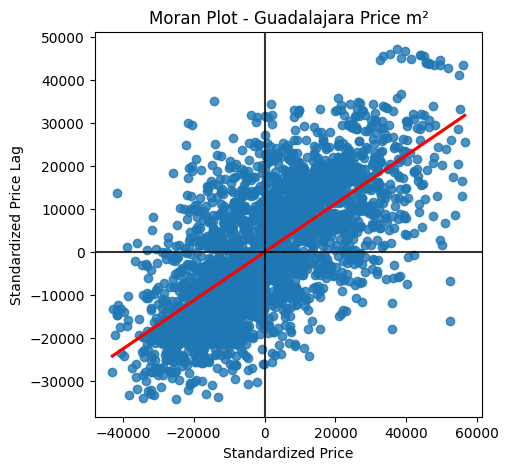

In [10]:
f, ax = plt.subplots(1, figsize=(5, 5))
sns.regplot(
    x='price_m2_std', # variable of interest
    y='price_m2_lag_std', # spatial lag
    ci=None, # suppress the plotting of the confidence interval
    data=gdf_properties, # dataset
    line_kws={'color':'r'}
)

ax.axvline(0, c='k', alpha=0.8)
ax.axhline(0, c='k', alpha=0.8)

ax.set_title('Moran Plot - Guadalajara Price m²')
ax.set_xlabel('Standardized Price')
ax.set_ylabel('Standardized Price Lag')
plt.show()

Morans I: 0.562456
p-value: 0.001


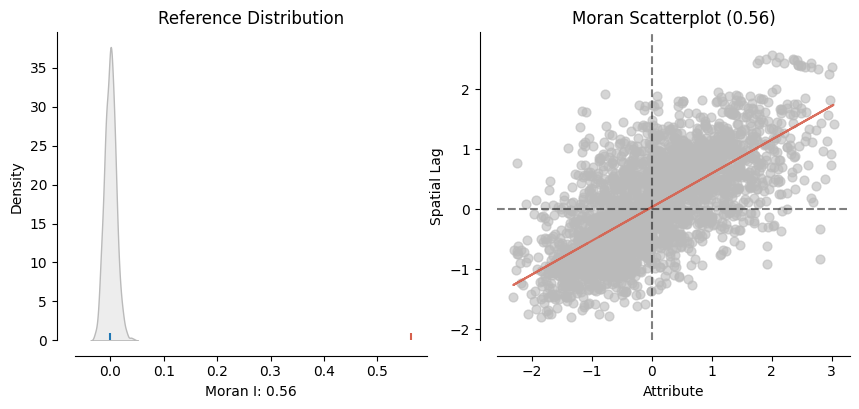

In [11]:
morans_stat = esda.moran.Moran(gdf_properties['price_per_m2'], w)
print(f'Morans I: {morans_stat.I:.6}')
print(f'p-value: {morans_stat.p_sim}')
splot.esda.plot_moran(morans_stat)
plt.show()

In [12]:
# create spatial weights with 5 neighbors
w = libpysal.weights.KNN.from_dataframe(gdf_properties[numeric_cols + ['geometry']], k=5)

# Global Moran's I
moran = esda.Moran(gdf_properties['price_per_m2'], w=w)
print(f'Moran\'s I: {moran.I:.4}, p-value: {moran.p_sim}')

# Local Moran's I
lisa = esda.Moran_Local(gdf_properties['price_per_m2'], w=w)
gdf_properties['lisa_cluster'] = lisa.q  # 1=HH, 2=LH, 3=LL, 4=HL

Moran's I: 0.5625, p-value: 0.001


/home/gus/Documents/github_repos/notes.git/venv/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


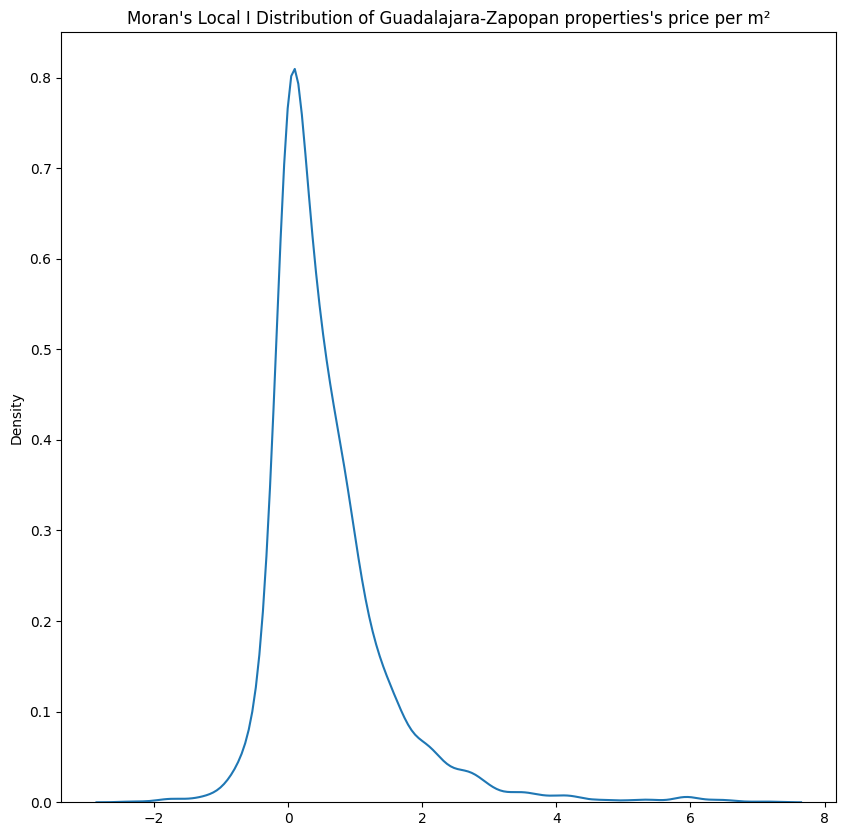

In [16]:
# Draw KDE line
f, ax = plt.subplots(1, figsize=(10, 10))
sns.kdeplot(lisa.Is, ax=ax)
plt.title('Moran\'s Local I Distribution of Guadalajara-Zapopan properties\'s price per m²')
plt.show()

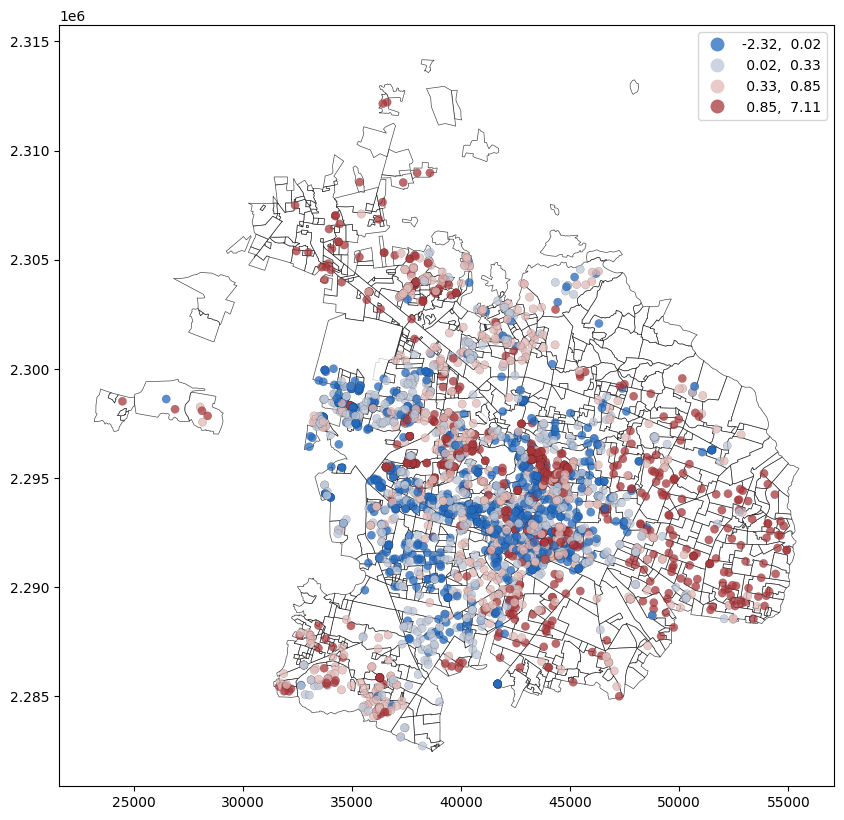

In [14]:
f, ax = plt.subplots(1, figsize=(10, 10))
gdf_neighborhoods.plot(
    ax=ax,
    color='white',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.7
    )
# Create a new column with the values from the Moran's Local LISAs
gdf_properties.assign(
    ML_Is=lisa.Is
    
# Plot choropleth of local statistics
).plot(
    column='ML_Is', 
    cmap='vlag', 
    scheme='quantiles',
    k=4, 
    edgecolor='black', 
    linewidth=0.1, 
    alpha=0.75,
    legend=True,
    ax=ax
)

plt.show()

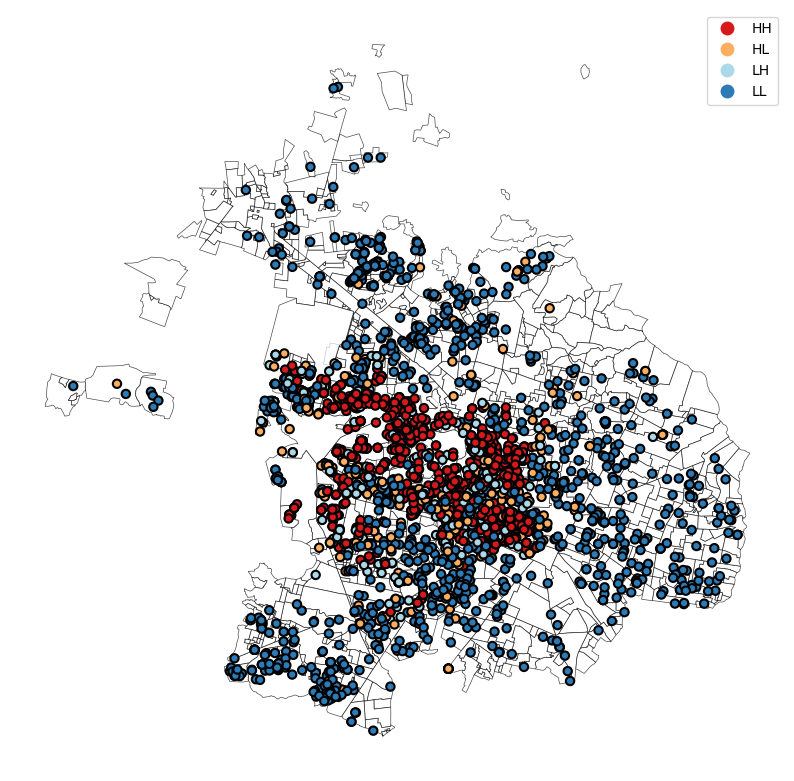

In [15]:
f, ax = plt.subplots(1, figsize=(10, 10))
gdf_neighborhoods.plot(
    ax=ax,
    color='white',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.7
    )
splot.esda.lisa_cluster(lisa, gdf_properties, p=1, ax=ax, edgecolor='black')
plt.show()